In [1]:
import pandas as pd
#from sep_util import read_file
import utm
import numpy as np
import h5py
import time
import tqdm
import obspy
import datetime
import os

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 18, # fontsize for x and y labels (was 10)
    'axes.titlesize': 18,
    'font.size': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'text.usetex':False,
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white'
}
matplotlib.rcParams.update(params)

In [2]:
# Adding pyDAS location
pyDAS_path = "/home/yinjx/DAS-utilities/build/"
import os
try:
    os.environ['LD_LIBRARY_PATH'] += ":" + pyDAS_path
except:
    os.environ['LD_LIBRARY_PATH'] = pyDAS_path
import sys
sys.path.insert(0,pyDAS_path)
sys.path.insert(0,'/home/yinjx/DAS-utilities/python')
import DASutils
import importlib
importlib.reload(DASutils)

<module 'DASutils' from '/home/ebiondi/research/packages/DAS-proc/python/DASutils.py'>

In [3]:
data_dir = '/kuafu/DASdata/Ridgecrest_ODH3_2_Hourly/Ridgecrest_ODH3-2021-07-29 061539Z.h5'

In [25]:
data0, info = DASutils.readFile_HDF([data_dir], 0.5, 40.0, taper=0.05,filter=True,
                                        verbose=1, desampling=True, system="OptaSense", nChbuffer=5000)

data0 = data0.T
ntS = info['nt']
fs = info['fs']
das_dt = info['dt']
das_time = np.linspace(0.0, (ntS-1)*das_dt, ntS)

WARNING! Cannot desample


Processing data...: 100%|██████████| 1/1 [00:28<00:00, 28.28s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


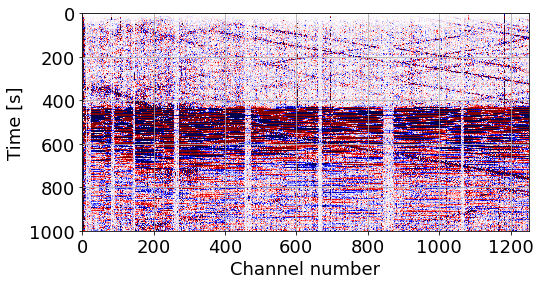

In [26]:
# Show data
fig, ax1 = plt.subplots(figsize=(8,4))
pclip=95
clipVal = np.percentile(np.absolute(data0), pclip)
# Vx
ax1.imshow(data0, 
        extent=[0, data0.shape[1], das_time[-1], das_time[0]],
        aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

# ax1.plot(np.arange(0, event_data.shape[1]), event_arrival_P[:, i_event], '--g', zorder=10)
# ax1.plot(np.arange(0, event_data.shape[1]), event_arrival_S[:, i_event], '-g', zorder=10)

ax1.set_xlabel("Channel number")
ax1.set_ylabel("Time [s]")
ax1.grid()
ax1.set_ylim(0, 1000)
ax1.invert_yaxis()
# ax1.set_title(f'Event id {eq_id[i_event]}, M {eq_mag[i_event]}')

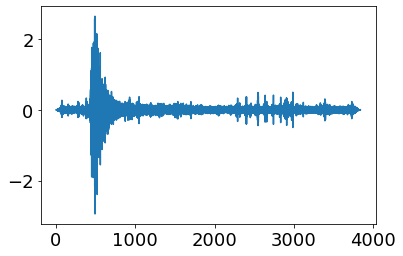

In [23]:
plt.plot(das_time, data0[:, 350])

In [3]:
data_dir = '/kuafu/DASdata/GoogleData/LAX36-LAX28/2022-02-01T17:20:29_2022-02-01T17:30:29.h5'

In [4]:
data0, info = DASutils.readFile_HDF([data_dir], 0.5, 40.0, taper=0.0,filter=False,
                                        verbose=1, desampling=False, system="OptaSense", nChbuffer=5000)

data0 = data0.T
ntS = info['nt']
fs = info['fs']
das_dt = info['dt']
das_time = np.linspace(0.0, (ntS-1)*das_dt, ntS)

Processing data...: 100%|██████████| 1/1 [00:06<00:00,  6.34s/it]


WARNING! Missing GaugeLength, Fibre Refractive Index, and Laser Wavelength info from metadata. Skipping data strain conversion!


In [5]:
with h5py.File(data_dir,'r') as fid:
    
    G = fid["Data"].attrs['GaugeLength']
    lam = fid["Data"].attrs['LaserWavelength']
    n = fid["Data"].attrs['RefractiveIndex']
    ChSamp = fid['Data'].attrs['ChSamp']
    conversion_factor = lam / (0.78 * 4 * np.pi * n * G) *1e6 # convert to micro strain

    data0 = fid["Data"][:] * conversion_factor
    ntS = fid["Data"].attrs['nt']
    fs = fid["Data"].attrs['fs']
    das_dt = fid["Data"].attrs['dt']

In [11]:
Ridgecrest_conversion_factor = 1550.12 / (0.78 * 4 * np.pi * 1.46 * 8) / 1e3
Ridgecrest_conversion_factor

0.013539979604935503

In [8]:
conversion_factor

0.0052748064000397044

In [43]:
data_diff = np.diff(data0, axis=0)/das_dt
das_time = das_time[:-1]+das_dt/2

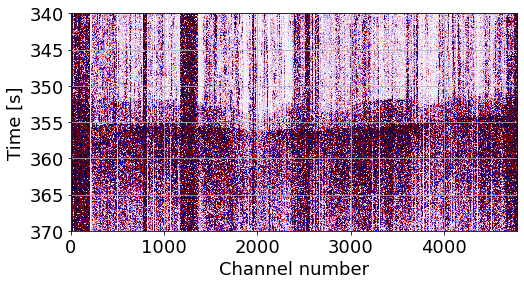

In [47]:
# Show data
fig, ax1 = plt.subplots(figsize=(8,4))
pclip=90
clipVal = np.percentile(np.absolute(data_diff), pclip)
# Vx
ax1.imshow(data_diff, 
        extent=[0, data_diff.shape[1], das_time[-1], das_time[0]],
        aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

# ax1.plot(np.arange(0, event_data.shape[1]), event_arrival_P[:, i_event], '--g', zorder=10)
# ax1.plot(np.arange(0, event_data.shape[1]), event_arrival_S[:, i_event], '-g', zorder=10)

ax1.set_xlabel("Channel number")
ax1.set_ylabel("Time [s]")
ax1.grid()
ax1.set_ylim(340, 370)
ax1.invert_yaxis()
# ax1.set_title(f'Event id {eq_id[i_event]}, M {eq_mag[i_event]}')

(340.0, 370.0)

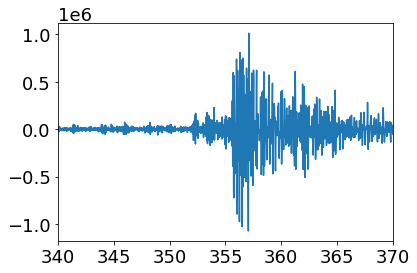

In [46]:
plt.plot(das_time, data_diff[:, 3300])
plt.xlim(340, 370)

In [19]:
import sys
sys.path.insert(0,'../')
from utility_functions import *


In [13]:
data_path = '/kuafu/EventData/LA_Google'

catalog = pd.read_csv(data_path + '/catalog.csv')
das_info = pd.read_csv(data_path + '/das_info.csv')

In [14]:
temp_catalog = catalog[catalog.magnitude >=3]
temp_catalog

,event_id,event_time,latitude,longitude,depth_km,magnitude,magnitude_type,source
202,39882375,2021-12-08T10:28:04.820000+00:00,34.20050,-117.50683,5.0,3.62,mw,scsn
225,39883351,2021-12-09T06:38:13.660000+00:00,34.31850,-119.45267,7.2,3.49,ml,scsn
596,39894823,2021-12-23T12:44:24.480000+00:00,33.37117,-116.88567,4.6,3.12,ml,scsn
823,39900159,2021-12-31T19:27:58.900000+00:00,34.03467,-117.20800,14.4,3.38,ml,scsn
1014,39905711,2022-01-08T06:21:31.650000+00:00,34.43650,-118.99117,1.8,3.56,ml,scsn
1039,39906383,2022-01-08T23:46:18.060000+00:00,33.37300,-116.88683,4.6,3.21,ml,scsn
1176,39910255,2022-01-13T03:19:08.700000+00:00,33.46883,-116.44300,14.0,3.86,mw,scsn
1399,39914199,2022-01-17T00:02:29.990000+00:00,34.43867,-119.29850,10.4,3.19,ml,scsn
1438,39915287,2022-01-18T07:39:15.120000+00:00,33.82550,-116.75067,12.5,3.45,mw,scsn
1601,39920079,2022-01-22T01:01:42.300000+00:00,32.86250,-116.08050,7.2,3.01,ml,scsn


(33.8, 34.1)

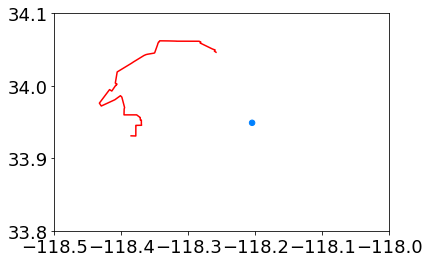

In [28]:
fig, ax = plt.subplots()
ax.plot(das_info.longitude, das_info.latitude, '-r')
ax.scatter(temp_catalog.longitude, temp_catalog.latitude, s=30, c=temp_catalog.magnitude, cmap='jet')
ax.set_xlim(-118.5, -118)
ax.set_ylim(33.8, 34.1)

In [17]:
def load_phase_pick(pick_path, eq_id, das_time, channel, time_range=None, include_nan=False):
    picks = pd.read_csv(pick_path + f'/{eq_id}.csv')

    picks_P = picks[picks.phase_type == 'P'].drop_duplicates(subset=['channel_index'], keep='first')
    picks_S = picks[picks.phase_type == 'S'].drop_duplicates(subset=['channel_index'], keep='first')


    # Adding restriction on the time
    if time_range is not None:
        dt = das_time[1] - das_time[0]
        picks_P = picks_P[(picks_P.phase_type == 'P') & 
                            (picks_P.phase_index <= time_range[1]/dt) & 
                            (picks_P.phase_index >= time_range[0]/dt)]

        picks_S = picks_S[(picks_S.phase_type == 'S') & 
                            (picks_S.phase_index <= time_range[3]/dt) & 
                            (picks_S.phase_index >= time_range[2]/dt)]

    if include_nan:
        picks_P_time = np.ones(channel.shape) * np.nan
        picks_S_time = np.ones(channel.shape) * np.nan
        ii_p = channel.isin(picks_P.channel_index.unique())#picks_P.channel_index.isin(channel)
        ii_s = channel.isin(picks_S.channel_index.unique())#picks_S.channel_index.isin(channel)

        ii_p_picks = picks_P.channel_index.isin(channel)
        ii_s_picks = picks_S.channel_index.isin(channel)

        picks_P_time[ii_p] = das_time[picks_P.phase_index[ii_p_picks]]
        picks_S_time[ii_s] = das_time[picks_S.phase_index[ii_s_picks]]
        channel_P, channel_S = channel, channel

    else:
        picks_P_time = das_time[picks_P.phase_index]
        channel_P = channel[picks_P.channel_index]

        picks_S_time = das_time[picks_S.phase_index]
        channel_S = channel[picks_S.channel_index]

    return picks_P_time, channel_P, picks_S_time, channel_S

In [20]:
# Setup the paths


event_id = 39929895

event_data, event_info = load_event_data(data_path + '/data', event_id)

das_dt = event_info['dt_s']
ntS = event_data.shape[0]

das_time = np.linspace(0.0, (ntS-1)*das_dt, ntS)-30

In [21]:
event_info

{'begin_time': datetime.datetime(2022, 2, 1, 17, 25, 46, 480000, tzinfo=tzutc()),
 'das_array': 'LAX',
 'depth_km': 15.800000000000001,
 'dt_s': 0.01,
 'dx_m': 10.209524154663086,
 'end_time': datetime.datetime(2022, 2, 1, 17, 27, 46, 480000, tzinfo=tzutc()),
 'event_id': 39929895,
 'event_time': datetime.datetime(2022, 2, 1, 17, 26, 16, 480000, tzinfo=tzutc()),
 'latitude': 33.948999999999998,
 'longitude': -118.20483,
 'magnitude': 3.2599999999999998,
 'magnitude_type': 'ml',
 'source': 'scsn'}

In [20]:
pick_path = '/kuafu/EventData/LA_Google/picks_phasenet_das'

pick_P, channel_P, pick_S, channel_S = load_phase_pick(pick_path, event_id, das_time, das_info.index, [0, 90, 0, 90], include_nan=True)

In [58]:
event_info

{'begin_time': datetime.datetime(2022, 2, 1, 17, 25, 46, 480000, tzinfo=tzutc()),
 'das_array': 'LAX',
 'depth_km': 15.800000000000001,
 'dt_s': 0.01,
 'dx_m': 10.209524154663086,
 'end_time': datetime.datetime(2022, 2, 1, 17, 27, 46, 480000, tzinfo=tzutc()),
 'event_id': 39929895,
 'event_time': datetime.datetime(2022, 2, 1, 17, 26, 16, 480000, tzinfo=tzutc()),
 'latitude': 33.948999999999998,
 'longitude': -118.20483,
 'magnitude': 3.2599999999999998,
 'magnitude_type': 'ml',
 'source': 'scsn'}

(0.0, 30.0)

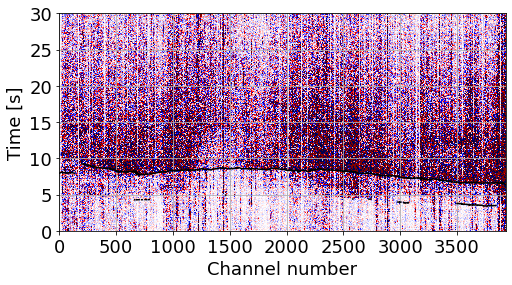

In [21]:
# Show data
fig, ax1 = plt.subplots(figsize=(8,4))
pclip=95
clipVal = np.percentile(np.absolute(event_data), pclip)
# Vx
ax1.imshow(event_data, 
        extent=[0, event_data.shape[1], das_time[-1], das_time[0]],
        aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))
ax1.plot(channel_P, pick_P, '-k')
ax1.plot(channel_S, pick_S, '-k')
# ax1.plot(np.arange(0, event_data.shape[1]), event_arrival_P[:, i_event], '--g', zorder=10)
# ax1.plot(np.arange(0, event_data.shape[1]), event_arrival_S[:, i_event], '-g', zorder=10)

ax1.set_xlabel("Channel number")
ax1.set_ylabel("Time [s]")
ax1.grid()

ax1.set_ylim(0, 30)


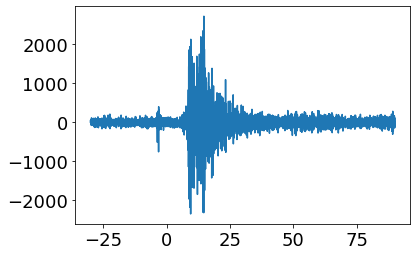

In [60]:
plt.plot(das_time, event_data[:, 2000])

In [53]:
event_data.shape

(11999, 3926)

In [30]:
raw_data_file = '/kuafu/EventData/LA_Google/sensor_2022-02-01T172529Z.h5'
fid = h5py.File(raw_data_file, 'r')

In [31]:
fid.keys()

<KeysViewHDF5 ['Acquisition']>

In [38]:
raw_data = fid['Acquisition']['Raw[0]']['RawData'][:]

In [39]:
raw_data.shape

(4780, 120000)

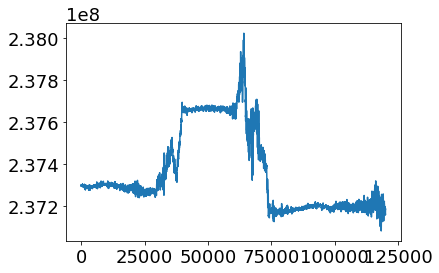

In [40]:
plt.plot(das_time0, raw_data[100, :])

In [42]:
ntS = raw_data.shape[1]
das_dt = 60/ntS
das_time0 = np.linspace(0.0, (ntS-1)*das_dt, ntS)
data_diff = np.gradient(raw_data, axis=1)/das_dt # to strain rate

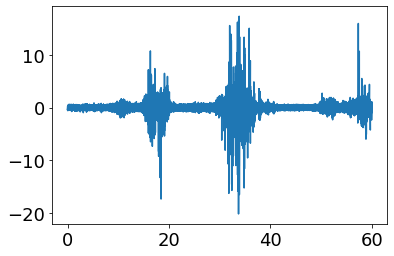

In [48]:
plt.plot(das_time0, data_diff[100, :]*conversion_factor*2*np.pi/2**16)

In [45]:
2**16

65536

In [51]:
ChSamp

10.209524154663086